In [36]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as L
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 

In [37]:
class TrainingConfig():
    epochs = 5
    batch_size= 128
    learningRate=0.001
    valRate=0.1
    loss=['sparse_categorical_crossentropy']
    metrics=['accuracy']
    optimizer='adam'
    
class WordEmbedding():
    sequenceLength=256
    wordCount=10000
    wordDim=10

class DataSourceConfig():
    source=["./dataset/imdb_train_data.npy",
           "./dataset/imdb_test_data.npy",
           "./dataset/imdb_train_labels.npy",
           "./dataset/imdb_test_labels.npy"]

In [105]:
class TextRCNN():
    def __init__(self,config,wordEmbedding):
        
        self.model = None
        self.history = None
        self.config=config
        self.emb=wordEmbedding
        self.name="TextRCNN"
      
    
    def design_model(self,hiden_size=32,with_fc=False):
        input_layer=L.Input(shape=(None,),name='feature_input')
        w=L.Embedding(input_dim=self.emb.wordCount,output_dim=self.emb.wordDim,input_length=self.emb.sequenceLength)(input_layer)
        x=w
        lx,rx=L.Bidirectional(L.LSTM(hiden_size,dropout=0.4,return_sequences=True),merge_mode=None)(x)
        x=L.concatenate([lx,w,rx])
        x=L.Dense(x.shape[-1],activation="tanh")(x)
        #x=L.Conv1D(filters=1,kernel_size=3,activation="relu")(x)
        x=L.GlobalMaxPool1D()(x)
        
        
        if with_fc:
            x=L.Dense(hiden_size,activation='relu')(x)
        
        output_layer=L.Dense(2,activation='softmax')(x)
        model=K.models.Model(inputs=[input_layer],outputs=[output_layer],name=self.name)
        self.model=model
        model.summary()
        return model
    
    
    def design_model_with_bilstm_2DCNN(self,hiden_size=32,with_fc=False):
        #要进行展平所以必须确定输入长度
        input_layer=L.Input(shape=(self.emb.sequenceLength,),name='feature_input')
        x=L.Embedding(input_dim=self.emb.wordCount,output_dim=self.emb.wordDim,input_length=self.emb.sequenceLength)(input_layer)
        x=L.Bidirectional(L.LSTM(hiden_size,dropout=0.4,return_sequences=True))(x)
        x=tf.expand_dims(x,-1)
        x=L.Conv2D(filters=5,kernel_size=3,activation='relu')(x)
        x=L.MaxPool2D(strides=2)(x)
        x=L.Flatten()(x)
        x=L.Dropout(0.5)(x)
        if with_fc:
            x=L.Dense(hiden_size,activation='relu')(x)
        output_layer=L.Dense(2,activation='softmax')(x)
        model=K.models.Model(inputs=[input_layer],outputs=[output_layer],name=self.name)
        self.model=model
        model.summary()
        return model
        
    
    def compile_model(self):
        #assert()
        if not self.model:
            print("Call design_modelXX() to build the model first.")
            return
        self.model.compile(optimizer=self.config.optimizer,loss=self.config.loss,metrics=self.config.metrics)

    def train_model(self,x,y):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
            return
        self.compile_model()
        self.history=self.model.fit(x=x,y=y,batch_size=self.config.batch_size,epochs=self.config.epochs,validation_split=self.config.valRate)
        #self.model.compile()
    
    def save_model(self):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        pass
    
    def eval_model(self):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        pass
    
    def view_train(self):
        if not self.history:
            print("Model has not been trained, train it first")
            return
        
        train=self.history.history["loss"]
        valid=self.history.history["val_loss"]
        name='loss'
        plt.title('The %s with epoch runs'%name,fontsize=30)
        plt.xlabel('epoch',fontsize=20)
        plt.ylabel(name,fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(train,label=name)
        plt.plot(valid,label="val_"+name)
        plt.legend()
        plt.gcf().set_size_inches(15,4)
        plt.show()
    #model=K.models.Model(inputs=[input_layer],outputs=[output_layer])
    #model.compile('adam',loss='categorical_crossentropy',metrics=metrics)
    #return model

In [108]:
train_config=TrainingConfig()
word_embedding=WordEmbedding()
model=TextRCNN(train_config,word_embedding)

In [109]:
model.design_model(with_fc=False)

Model: "TextRCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, None, 10)     100000      feature_input[0][0]              
__________________________________________________________________________________________________
bidirectional_26 (Bidirectional [(None, None, 32), ( 11008       embedding_26[0][0]               
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, None, 74)     0           bidirectional_26[0][0]           
                                                                 embedding_26[0][0]        

In [110]:
class Dataset():
    def __init__(self,config):
        self.config=config
    def load(self):
        L=[]
        for item in self.config.source:
            L.append(np.load(item,allow_pickle=True, fix_imports=True))
        return L

In [111]:
data=Dataset(DataSourceConfig)
train_data,test_data,train_labels,test_labels=data.load()

In [112]:
model.train_model(x=train_data,y=train_labels)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 9s 392us/sample - loss: 0.5497 - accuracy: 0.7220 - val_loss: 0.3173 - val_accuracy: 0.8728
Epoch 2/5
22500/22500 [==============================] - 6s 264us/sample - loss: 0.2605 - accuracy: 0.8939 - val_loss: 0.2832 - val_accuracy: 0.8892
Epoch 3/5
22500/22500 [==============================] - 7s 333us/sample - loss: 0.1962 - accuracy: 0.9242 - val_loss: 0.2752 - val_accuracy: 0.8904
Epoch 4/5
22500/22500 [==============================] - 6s 258us/sample - loss: 0.1628 - accuracy: 0.9388 - val_loss: 0.2919 - val_accuracy: 0.8892
Epoch 5/5
22500/22500 [==============================] - 6s 276us/sample - loss: 0.1354 - accuracy: 0.9482 - val_loss: 0.3423 - val_accuracy: 0.8812


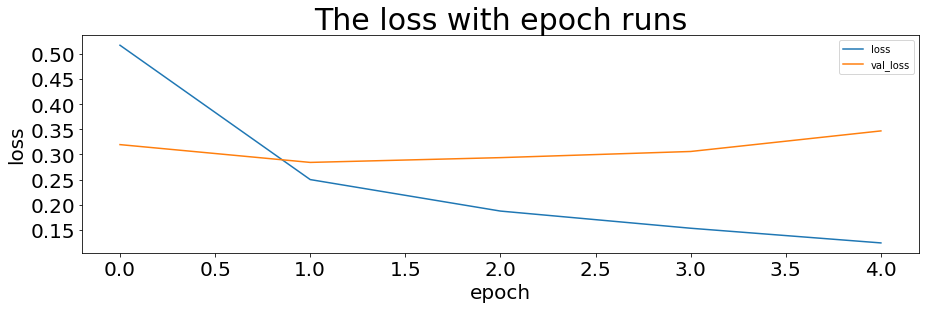

In [44]:
model.view_train()